<a href="https://colab.research.google.com/github/apantovic/loan_recommendation/blob/master/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !pip install catboost
# !pip install ipywidgets
# !pip install shap
# !jupyter nbextension enable --py widgetsnbextension
# !pip install pyreadr
# !pip install category_encoders
import pyreadr
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import shap
from catboost import FeaturesData, Pool, CatBoostClassifier, cv
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix,roc_curve, roc_auc_score
import category_encoders as ce
from sklearn.linear_model import LogisticRegression
from random import seed
from random import random, randint
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt    

import rpy2
from rpy2 import robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def load_rdata_file(filename):
    r_data = robjects.r['get'](robjects.r['load'](filename))
    df = pandas2ri.ri2py(r_data)
    return df

# write pandas dataframe to an .RData file
def save_rdata_file(df, filename):
    r_data = pandas2ri.py2ri(df)
    robjects.r.assign("my_df", r_data)
    robjects.r("save(my_df, file='{}')".format(filename))

In [0]:
d = 'gdrive/My Drive/Colab Notebooks/smava/' # directory location

In [0]:
df = pyreadr.read_r(d+'train.rdata')['train']

In [0]:
df.head()

,customerNumber,bank,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,accepted,interestRate
0,7544,B14,2.682055,11.100511,261.090837,4.026472,-1.487079,FBW,M98CB,2.419460,0.461507,0.270275,NO,NaN
1,9909,B4,1.174998,6.838129,276.160877,-3.232975,-4.936049,ACS,U5D5G,-7.633956,0.894344,0.250617,NO,NaN
2,24088,B25,1.894799,NaN,188.350538,2.199944,-3.312238,FBW,YVNYM,-1.373489,0.661539,0.389140,YES,2.259308
3,12700,B3,1.704409,5.412387,196.748617,-1.209511,1.852449,FBW,PBSEO,0.731694,0.267896,0.373103,NO,NaN
4,17866,B1,2.555469,3.211833,168.724380,2.495089,0.870745,FBW,IQ4NP,2.771730,0.200343,0.429355,NO,NaN


In [0]:
df['accepted'].isna().sum() # checking target column if there are any missings

0

In [0]:
df['accepted'].value_counts() # evenly distributed accross classes

NO     68364
YES    66605
Name: accepted, dtype: int64

In [0]:
# mapping to 1 and 0
df['accepted'] = df['accepted'].replace({'YES': 1, 'NO': 0})
df.describe()

,customerNumber,x1,x2,x3,x4,x5,x8,x9,x10,accepted,interestRate
count,134969.000000,134969.000000,94449.000000,134969.000000,134969.000000,134969.000000,134969.000000,134969.000000,134969.000000,134969.000000,66605.000000
mean,15053.880824,1.658951,8.171224,199.343592,1.958111,1.933979,3.891818,0.367628,0.379910,0.493484,5.316214
std,8674.519377,2.232039,23.352076,49.788212,4.004672,4.005958,5.715816,0.242489,0.096061,0.499959,3.102967
min,2.000000,0.024333,0.007799,13.352851,-13.548884,-13.641403,-19.435636,-0.101787,0.147159,0.000000,2.000616
25%,7551.000000,0.499919,0.967142,165.997255,-0.750850,-0.791354,-0.035724,0.186601,0.311541,0.000000,3.038332
50%,15105.000000,1.004598,2.714380,199.112717,1.996293,1.970558,3.932483,0.328365,0.368710,0.000000,4.418352
75%,22518.000000,1.957989,7.364886,232.734975,4.677582,4.631655,7.835693,0.504267,0.435263,1.000000,6.561225
max,29997.000000,75.799468,910.948335,382.409475,18.885490,18.283783,27.568832,1.092890,0.935279,1.000000,15.320000


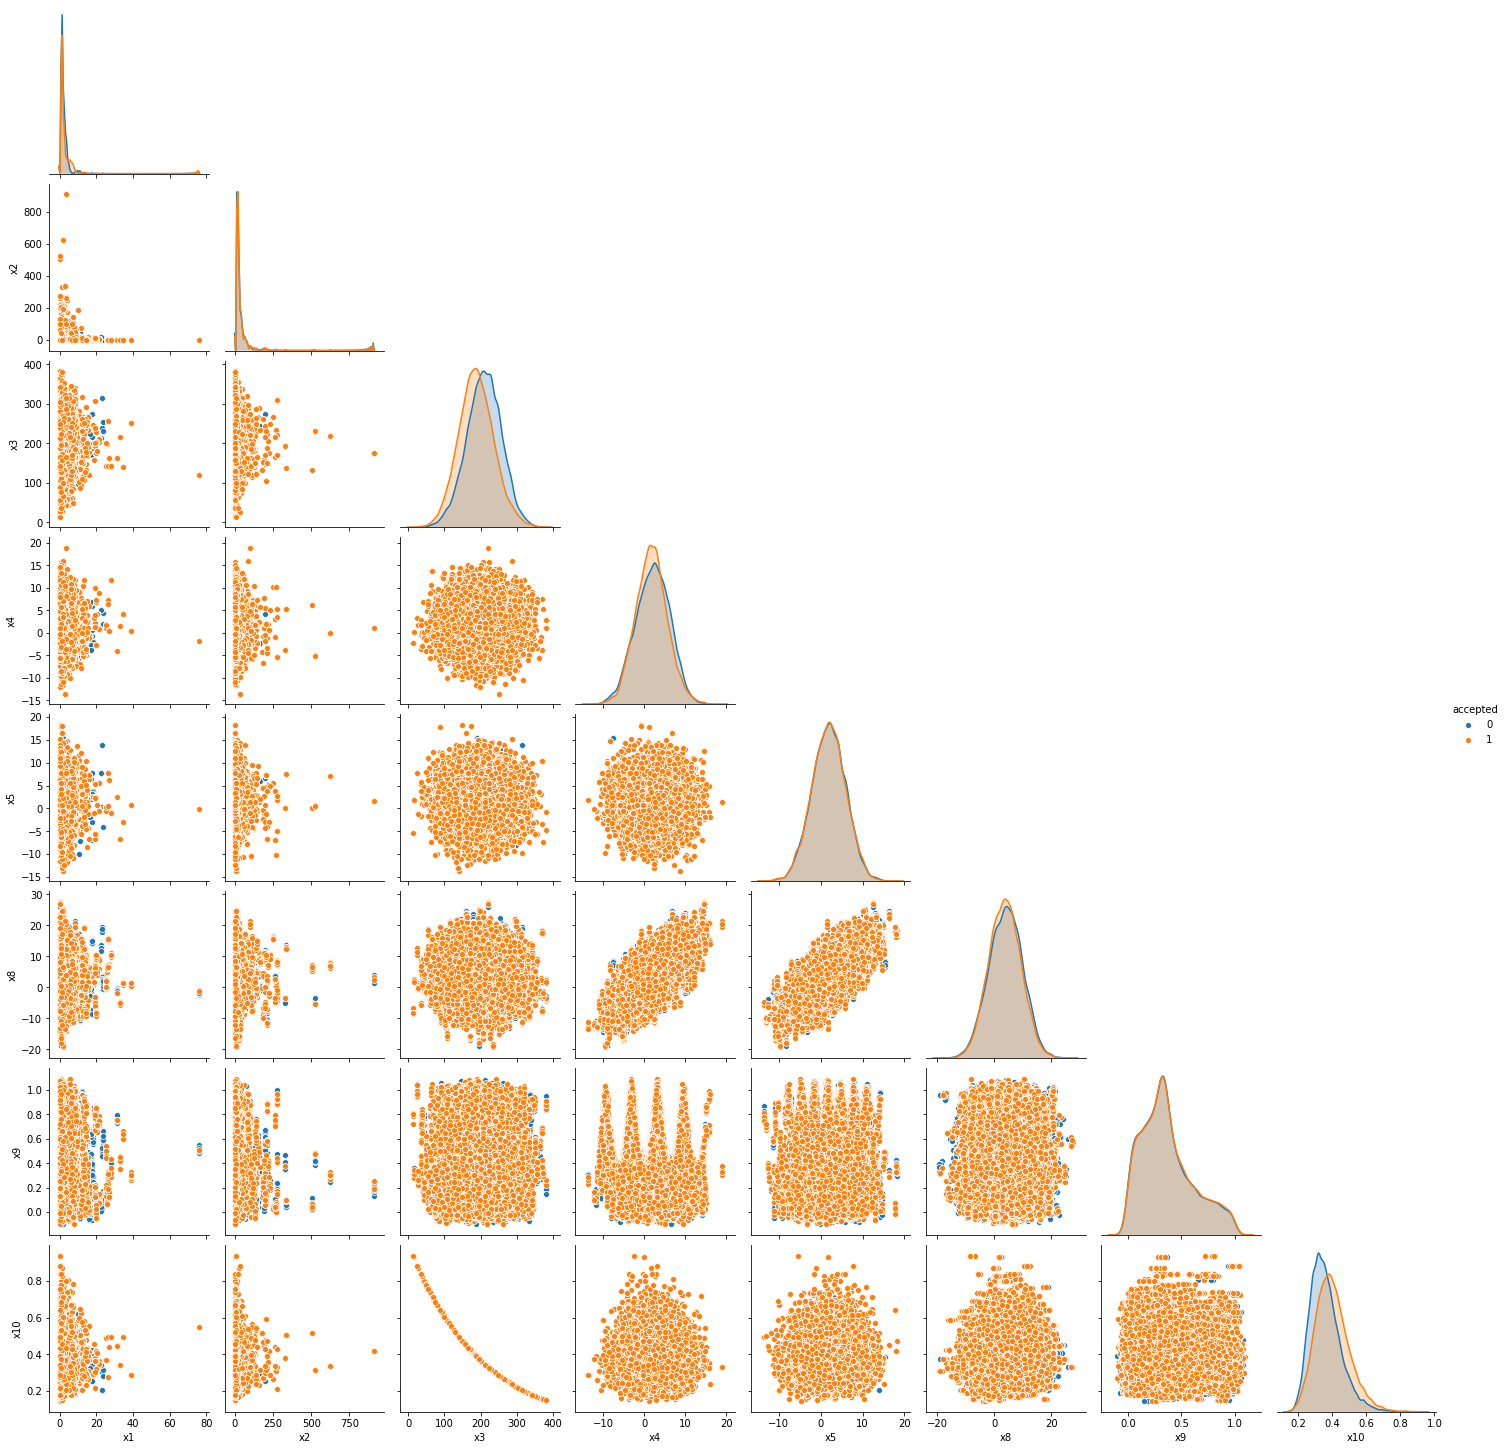

In [0]:
# visualize data
sns.pairplot(df, hue='accepted', vars=['x1','x2','x3','x4','x5','x8','x9','x10'], corner=True)

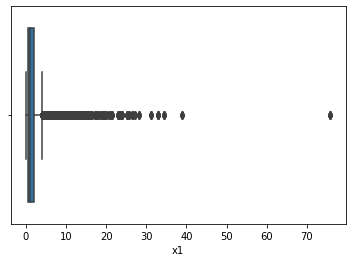

In [0]:
# x1 & x2 have fat tails
sns.boxplot(df['x1'])

In [0]:
# features/target separation
target = df[['accepted']]
df.drop(['accepted','interestRate','customerNumber','bank'], inplace=True, axis=1)

# replace data types for later use
for c in df.select_dtypes(include=['float64','int64', 'int32']).columns.tolist():
  df[c] = df[c].astype('float32')
for c in df.select_dtypes(include=['object','category']).columns.tolist():
  df[c] = df[c].astype(str)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.15, random_state=100)

# train/valid split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=100)

In [0]:
# capping outliers on x1 and x2
def treat_outliers(df, column):
    'Outlier treatment using 1.5*IQR range to detect outliers. Input/Output-> pandas Series'

    Q1 = np.quantile(df[column].dropna(),0.25)
    Q3 = np.quantile(df[column].dropna(),0.75)
    IQR = Q3 - Q1
    upper = Q3+3*IQR
    lower = Q1-3*IQR

    df.loc[df[column]>upper,column] = upper
    df.loc[df[column]<lower,column] = lower
    
    return df[column]

X_train['x1'] = treat_outliers(X_train,'x1')
X_train['x2'] = treat_outliers(X_train,'x2')

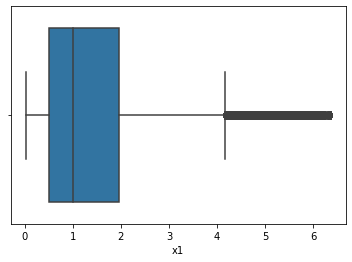

In [0]:
sns.boxplot(x=X_train['x1'])

In [0]:
X_train.head(3)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
25929,3.039076,NaN,199.955948,9.248883,-2.203132,FBW,M00LK,7.956191,0.700060,0.367155
18830,0.634971,0.213561,189.486206,-3.361001,-2.999108,FBW,2K27J,-6.568861,0.059747,0.386931
112743,0.090244,4.111392,261.754059,-2.703896,-0.204326,ACS,QTDO0,-3.636394,0.187661,0.269378


In [0]:
# prepare data and run grid search to find best hyperparameters for the model
cat = X_train.select_dtypes(include=['object']).columns.tolist()
num = X_train.select_dtypes(include=['float32']).columns.tolist()

train_data = Pool(
    data=FeaturesData(
        num_feature_data=X_train[num].values,
        num_feature_names=num,
        cat_feature_data=X_train[cat].values,
        cat_feature_names=cat
    ),
    label=y_train
)

val_data = Pool(
    data=FeaturesData(
        num_feature_data=X_val[num].values,
        num_feature_names=num,
        cat_feature_data=X_val[cat].values,
        cat_feature_names=cat
    ),
    label=y_val
)

test_data = Pool(
    data=FeaturesData(
        num_feature_data=X_test[num].values,
        num_feature_names=num,
        cat_feature_data=X_test[cat].values,
        cat_feature_names=cat
    )
)

parameters = {'depth'         : sp_randInt(2, 6),
              'learning_rate' : sp_randFloat(0.001,0.3),
              'iterations'    : sp_randInt(100, 200),
                 }

model = CatBoostClassifier()
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, 
                               cv = 10, n_iter = 20, n_jobs=-1)
randm.fit(X_train, y_train,
          cat_features=cat,
          eval_set=(X_val, y_val)
 )


0:	learn: 0.6810454	test: 0.6813663	best: 0.6813663 (0)	total: 22.5ms	remaining: 3.51s
1:	learn: 0.6715402	test: 0.6721290	best: 0.6721290 (1)	total: 40.5ms	remaining: 3.14s
2:	learn: 0.6640719	test: 0.6648470	best: 0.6648470 (2)	total: 56.8ms	remaining: 2.92s
3:	learn: 0.6593670	test: 0.6602534	best: 0.6602534 (3)	total: 72.6ms	remaining: 2.77s
4:	learn: 0.6550221	test: 0.6561919	best: 0.6561919 (4)	total: 90.3ms	remaining: 2.75s
5:	learn: 0.6516332	test: 0.6529389	best: 0.6529389 (5)	total: 106ms	remaining: 2.68s
6:	learn: 0.6489040	test: 0.6502919	best: 0.6502919 (6)	total: 123ms	remaining: 2.63s
7:	learn: 0.6466675	test: 0.6481857	best: 0.6481857 (7)	total: 138ms	remaining: 2.57s
8:	learn: 0.6450896	test: 0.6466352	best: 0.6466352 (8)	total: 154ms	remaining: 2.53s
9:	learn: 0.6437306	test: 0.6452789	best: 0.6452789 (9)	total: 170ms	remaining: 2.5s
10:	learn: 0.6426455	test: 0.6442270	best: 0.6442270 (10)	total: 186ms	remaining: 2.47s
11:	learn: 0.6416086	test: 0.6432577	best: 0.643

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f56bf855438>,
                   iid='deprecated', n_iter=20, n_jobs=-1,
                   param_distributions={'depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f56bf855588>,
                                        'iterations': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f56c0c66198>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f56c0c66b70>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [0]:
print("\n The best score across ALL searched params:\n",randm.best_score_)

print("\n The best parameters across ALL searched params:\n",randm.best_params_)


 The best score across ALL searched params:
 0.6507115479775453

 The best parameters across ALL searched params:
 {'depth': 5, 'iterations': 157, 'learning_rate': 0.15588333286328884}


In [0]:
# fit model based on best parameters
model = CatBoostClassifier(iterations=5000, 
                          depth=5, 
                          learning_rate=0.15,
                          random_seed=100,
                          use_best_model=True,
                          loss_function='CrossEntropy')

model.fit(train_data,eval_set=val_data, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [0]:
model.save_model(d+'01smava.dump')

y_pred_prob = np.array([item[1] for item in model.predict_proba(test_data)])
y_pred = model.predict(test_data)
print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test,y_pred))

print('AUC: ',roc_auc_score(y_test, y_pred_prob))

print('Gini: ',2*roc_auc_score(y_test, y_pred_prob)-1)

[[7114 3155]
 [3924 6053]]
              precision    recall  f1-score   support

           0       0.64      0.69      0.67     10269
           1       0.66      0.61      0.63      9977

    accuracy                           0.65     20246
   macro avg       0.65      0.65      0.65     20246
weighted avg       0.65      0.65      0.65     20246

AUC:  0.6981349391066587
Gini:  0.3962698782133174


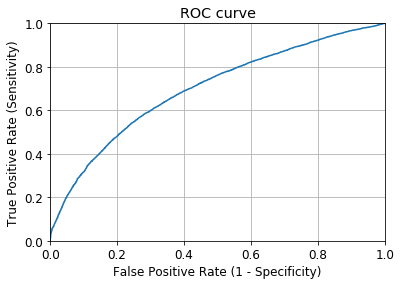

In [0]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)


In [0]:
feature_importances = model.get_feature_importance(train_data)
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    if score>0:
      print('{}: {}'.format(name, score))

x1: 41.26136199048017
x4: 16.099912727114024
x3: 15.299332421267287
x8: 13.557258504914088
x10: 3.1017418898729208
x5: 2.779051393591511
x7: 2.7756435241824677
x6: 2.5528566986361616
x2: 2.1149192080750088
x9: 0.4579216418663357


In [0]:
# score data and write pandas dataframe to an .RData file
def score_df(model, df):
  
  cat = ['x6','x7']
  num = ['x1','x2','x3','x4','x5','x8','x9','x10']

  for c in df.select_dtypes(include=['float64','int64', 'int32']).columns.tolist():
    df[c] = df[c].astype('float32')
  for c in df.select_dtypes(include=['object','category']).columns.tolist():
    df[c] = df[c].astype(str)
  df['customerNumber'] = df['customerNumber'].astype('int32')

  data = Pool(
      data=FeaturesData(
          num_feature_data=df[num].values,
          num_feature_names=num,
          cat_feature_data=df[cat].values,
          cat_feature_names=cat
      ))
  df['predictionAccepted'] = np.array([item[1] for item in model.predict_proba(data)])
  return df

# save predictions
test_df = pyreadr.read_r(d+'test.rdata')['test']
test_df = score_df(model, test_df)

save_rdata_file(test_df, d+'Results/predictions.rdata')
test_df.to_csv(d+'Results/predictions.csv')

In [0]:
# visualize features that affect output
shap_values = model.get_feature_importance(test_data, type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X_test.iloc[3,:])

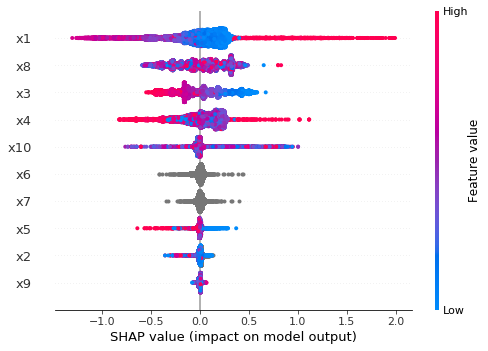

In [0]:
shap.summary_plot(shap_values, X_test)

### Feature importance based on IV

In [0]:
def woe_iv(good,bad,target):
  """
  Author: Aleksandar Pantovic
  -----------Desc-------------
  Calculates Weight of Evidence and Information value for specified variable(s)
  -----------Input------------
  good - DataFrame or pandas Series with info about non-event (perfoming cases)
  bad -  DataFrame or pandas Series with info about event (non-perfoming cases)
  -----------Output-----------
  pandas Series with calculated WoE and IV values
  """
  total_good=np.subtract(target.count(),np.sum(target))
  total_bad=np.sum(target)
  woe=np.log(np.divide(np.divide(good,total_good[0]),
                        np.divide(bad,total_bad[0]))).replace(np.inf,0.000001)
  iv = np.multiply(woe,np.subtract(np.divide(good,total_good[0]),np.divide(bad,total_bad[0]))).replace(np.inf,0.000001)

  cum_bad_pct=np.divide(bad.cumsum(),np.sum(bad))
  cum_good_pct=np.divide(good.cumsum(),np.sum(good))
  cum_bad_pct_lag=cum_bad_pct.shift(1).replace(np.nan,0)
  cum_good_pct_lag=cum_good_pct.shift(1).replace(np.nan,0)

  gini=abs(np.subtract(1,
                    np.sum(np.multiply(
                        np.add(cum_good_pct,cum_good_pct_lag),
                        np.subtract(cum_bad_pct,cum_bad_pct_lag)))))

  iv_var=abs(np.sum(iv))

  return woe,iv,gini,iv_var

def fine_classing(df,var,target):
    
    """
    Author: Aleksandar Pantovic
    Fine Classing function that divides continuous variable into 20 appx equal groups

    Parameters:
    -----------
    df : pandas DataFrame with all possible predictors and response

    var: name of the variable to create fine classes - insert as string -> 'var'
    
    gb: target variable with info about good/bad clients
    Returns:
    --------
    fine_class: dataframe with info about total number of observations, number of good, bad,
                bad rate, WoE and IV for each group
    gini_iv: dataframe with values of Gini and IV for whole variable
    """
    
    gb=target.columns[0]                                                              # name of the target column
    gini_iv=pd.DataFrame(columns=['gini','iv'],index=range(1))                             # empty dataframe

    if (df[var].nunique()>20) & (var not in df.select_dtypes(include=['object','category']).columns):  # if value is numeric and has more than 20 unique values
        groups = pd.DataFrame(data=pd.qcut(df[var],20,labels = False, duplicates='drop'))
        groups.fillna(-1,inplace=True)   
        groups.columns=['group']
        data = pd.merge(df[[var]], groups, left_index=True, right_index=True)
    else:
        if (df[var].nunique()>20) & (var in df.select_dtypes(include=['object','category']).columns):
            replace=df[var].value_counts()[21:].index
            df[var].replace(replace, 'Other')

        groups=pd.DataFrame(df[var].unique()).reset_index()
        groups.columns=['group','Old']
        data=df[[var]].merge(groups, how='left', left_on=var, right_on='Old')
        data=data[[var,'group']]

    data = pd.merge(data, target, left_index=True, right_index=True)

    min_max=data.groupby('group')[var].agg(['min','max']).rename(columns={'min':'Min','max':'Max'})

    fine_class = data.groupby('group')[gb].agg(['count','sum']).rename(columns={'count':'Total','sum':'Bad'})      #aggregates data to 20 groups with bad and total obs number
    fine_class = pd.merge(fine_class, min_max, left_index=True, right_index=True)
    fine_class['Good']=np.subtract(fine_class['Total'],fine_class['Bad'])
    fine_class['Bad_rate']=np.divide(fine_class['Bad'],fine_class['Total'])
    fine_class['WoE'],fine_class['IV'],gini,iv = woe_iv(fine_class['Good'],fine_class['Bad'],target)
    fine_class['Variable']=var
    fine_class=fine_class.reset_index()

    gini_iv['Gini']=gini 
    gini_iv['IV_var']=iv

    return fine_class, gini_iv[['Gini','IV_var']].iloc[0]



In [0]:
fine_class=pd.DataFrame(columns=['Min','Max','Total','Bad','Good','Bad_rate','WoE','IV','Variable'])
gini_iv={}

for var in ['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10']:
    fc,gini_iv[var]=fine_classing(X_train,var,y_train)

    fine_class=pd.concat([fine_class,fc])
fine_class = fine_class[['Min','Max','Total','Bad','Good','Bad_rate','WoE','IV','Variable']]


Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

divide by zero encountered in log


In [0]:
pd.DataFrame.from_dict(gini_iv, orient='index').sort_values(by='IV_var',ascending=False)

,Gini,IV_var
x3,0.255023,0.204466
x10,0.255036,0.204461
x1,0.066594,0.101732
x7,0.001387,0.041513
x4,0.055482,0.030348
x8,0.041136,0.010031
x2,0.003784,0.001642
x5,0.007458,0.001632
x9,0.008886,0.000968
x6,0.005822,0.000111


#### Based on histograms and IV variables X1, X3 and X10 should be kept, while model suggests X1, X3, X4 - but X10 is also of great importance for the model. Thus final decision is to keep  X1, X3 and X10 features.

## Task 3 - select which banks to contact

In [0]:
# read training data
df = pyreadr.read_r(d+'train.rdata')['train']

In [0]:
df.head()

,customerNumber,bank,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,accepted,interestRate
0,7544,B14,2.682055,11.100511,261.090837,4.026472,-1.487079,FBW,M98CB,2.419460,0.461507,0.270275,NO,NaN
1,9909,B4,1.174998,6.838129,276.160877,-3.232975,-4.936049,ACS,U5D5G,-7.633956,0.894344,0.250617,NO,NaN
2,24088,B25,1.894799,NaN,188.350538,2.199944,-3.312238,FBW,YVNYM,-1.373489,0.661539,0.389140,YES,2.259308
3,12700,B3,1.704409,5.412387,196.748617,-1.209511,1.852449,FBW,PBSEO,0.731694,0.267896,0.373103,NO,NaN
4,17866,B1,2.555469,3.211833,168.724380,2.495089,0.870745,FBW,IQ4NP,2.771730,0.200343,0.429355,NO,NaN


In [0]:
# calculate probabilities based on catboost model
df = score_df(model, df)
df['accepted'] = df['accepted'].replace({'YES': 1, 'NO': 0})

In [0]:
# calibrate probabilities with selected banks
encoder = ce.OneHotEncoder(use_cat_names=True)
df_encoded = encoder.fit_transform(df[['bank','predictionAccepted']])
logreg = LogisticRegression(random_state=0).fit(df_encoded, df['accepted'])

In [0]:
df.head(3)

,customerNumber,bank,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,accepted,interestRate,predictionAccepted
0,7544,B14,2.682055,11.100511,261.090851,4.026472,-1.487079,FBW,M98CB,2.419460,0.461507,0.270275,0,NaN,0.271293
1,9909,B4,1.174998,6.838129,276.160889,-3.232975,-4.936049,ACS,U5D5G,-7.633956,0.894344,0.250617,0,NaN,0.247315
2,24088,B25,1.894799,NaN,188.350540,2.199944,-3.312238,FBW,YVNYM,-1.373489,0.661539,0.389140,1,2.259308,0.524413


In [0]:
df['predictionAcceptedWtd'] = np.round(np.array([item[1] for item in logreg.predict_proba(encoder.fit_transform(df[['bank','predictionAccepted']]))]),4)

In [0]:
df.head()

,customerNumber,bank,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,accepted,interestRate,predictionAccepted,predictionAcceptedWtd
0,7544,B14,2.682055,11.100511,261.090851,4.026472,-1.487079,FBW,M98CB,2.419460,0.461507,0.270275,0,NaN,0.271293,0.2559
1,9909,B4,1.174998,6.838129,276.160889,-3.232975,-4.936049,ACS,U5D5G,-7.633956,0.894344,0.250617,0,NaN,0.247315,0.2734
2,24088,B25,1.894799,NaN,188.350540,2.199944,-3.312238,FBW,YVNYM,-1.373489,0.661539,0.389140,1,2.259308,0.524413,0.5261
3,12700,B3,1.704409,5.412386,196.748611,-1.209511,1.852449,FBW,PBSEO,0.731694,0.267896,0.373103,0,NaN,0.520603,0.5597
4,17866,B1,2.555469,3.211833,168.724380,2.495089,0.870745,FBW,IQ4NP,2.771730,0.200343,0.429355,0,NaN,0.485233,0.5165


In [0]:
# creating matrix of probabilities and banks
pivotTableDF = pd.pivot_table(df[['interestRate','bank','predictionAcceptedWtd']],
                              index='predictionAcceptedWtd',
                              columns='bank',
                              values='interestRate',
                              aggfunc=np.min).fillna(0)

In [0]:
pivotTableDF.head()

bank,B1,B10,B11,B12,B13,B14,B15,B16,B17,B18,B19,B2,B20,B21,B22,B23,B24,B25,B26,B27,B28,B29,B3,B30,B4,B5,B6,B7,B8,B9
predictionAcceptedWtd,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.1710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.303918
0.1762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.29221,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
0.1788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,7.495690,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
0.1811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2.33978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
0.1835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,5.602939,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [0]:
# apply model to test data
test_df['predictionAcceptedWtd'] = np.array([item[1] for item in logreg.predict_proba(encoder.fit_transform(test_df[['bank','predictionAccepted']]))])

In [0]:
test_df.head()

,customerNumber,bank,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,predictionAccepted,predictionAcceptedWtd
0,17652,B4,2.699904,NaN,289.806000,3.506285,3.019291,ACS,P0DI0,6.132490,0.202469,0.234053,0.315085,0.296559
1,5083,B2,1.776817,NaN,149.480789,8.678540,1.561671,ACS,WXATN,9.602027,0.603551,0.472819,0.369944,0.399476
2,14485,B27,9.201461,15.201900,168.530548,0.686155,-2.659850,FBW,YVNYM,-1.843894,0.360468,0.429772,0.364234,0.345294
3,24278,B12,0.242509,0.890648,144.351913,8.994287,3.757424,ACS,WXATN,13.329597,0.210293,0.485128,0.436512,0.462376
4,18816,B29,1.861935,0.944171,330.278351,11.182924,1.795022,FBW,KT4RM,12.944497,0.119374,0.191090,0.629187,0.675904


In [0]:
# for each row test sample - wtd probabilities are filtered from matrix and banks are extracted
def make_rec(df,ref_df,iter):
    """
    Author: Aleksandar Pantovic
    Get recommendations which banks to contact one row at a time
    Parameters:
    -----------
    df : pandas DataFrame - used for features
    ref_df: pandas DataFrame - used for mapping
    iter: int - used to filter out row value
    Returns:
    --------
     res: string - all bank names to contact
    """

    p = df.iloc[iter]['predictionAcceptedWtd']
    try:
      idx = np.argwhere(ref_df.index>p)[0][0]
    except:
      return '{' + ', '.join(ref_df.columns) + '}'
    l_val = ref_df.iloc[idx]
    val = l_val[l_val>0].index.values
    res = ', '.join(val)
    return '{' + res + '}'

In [0]:
test_df['banks'] = test_df.apply(lambda row : make_rec(test_df, pivotTableDF, row.name), axis = 1) 

In [0]:
task3 = test_df[['customerNumber','banks']]
save_rdata_file(task3, d+'Results/banks.rdata')

In [0]:
task3.to_csv(d+'Results/banks.csv')